# Predictive maintenance with regression models
The goal is to calculate the RUL of the engines by using ML techniques. 

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from timeit import default_timer as timer   # for measuring computation time
from pympler import asizeof                 # for measuring ML object size

# import self defined functions
from add_remaining_useful_life import add_remaining_useful_life
from plot_sensor_signal import plot_sensor_signal
from evaluate import evaluate
from plot_sensor_std import plot_sensor_std


In [19]:
dir_path = './input/'
train_file = 'PM_train.txt'
train_location = dir_path + train_file
test_file = 'PM_test.txt'
test_location = dir_path + test_file
truth_file = 'PM_truth.txt'
truth_location = dir_path + truth_file

index_names = ['id', 'cycle']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names = ['s{}'.format(i+1) for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv(train_location, sep='\s+', header=None, names=col_names)    # s+ -> regex for spaces/tabs as spaces
test = pd.read_csv(test_location, sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(truth_location, sep='\s+', header=None, names=['RUL'])

print(train.shape)

(20631, 26)


In [20]:
# inspect cycles of train data
train[index_names].groupby('id').max().describe()

,cycle
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [21]:
# checking sensor data
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
s6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s10,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


Some sensor values have a standard deviation = 0, such as s1, s5, s16, s18, s19. Having a standard deviation of zero means that there these features are stationary thus not changing over time. 
Such sensor values are irrelevant when determining the RUL.  

In [22]:
# Computation of RUL
train = add_remaining_useful_life(train)
test = add_remaining_useful_life(test)
train[index_names+['RUL']].head()

,id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [23]:
# adjust RUL value by truth values
for i in range(len(test)):
    currentID = test['id'][i]
    current_truth_value = y_test['RUL'][currentID - 1]
    test['RUL'][i] = test['RUL'][i] + current_truth_value


,0
count,100.000000
mean,130.960000
std,53.593479
min,31.000000
25%,88.750000
50%,133.500000
75%,164.250000
max,303.000000


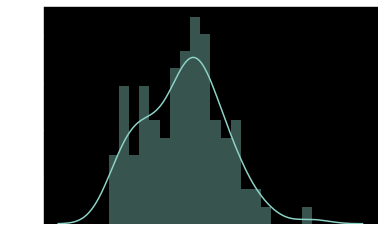

In [164]:
# get period duration of test dataset
list_periods = []
for i in range(0, len(test)):
    if i + 1 < len(test):
        if test['cycle'][i] > test['cycle'][i + 1]:
            list_periods.append(test['cycle'][i])
    else:
        list_periods.append(test['cycle'][i])
sns.distplot(list_periods, bins=20)
pd.DataFrame(list_periods).describe()


,0
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


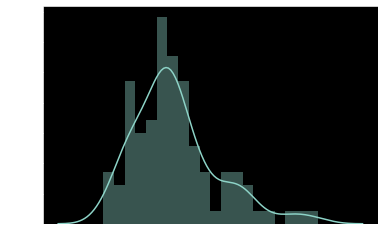

In [166]:
# get period duration of train dataset
list_periods_train = []
for i in range(0, len(train)):
    if i + 1 < len(train):
        if train['cycle'][i] > train['cycle'][i + 1]:
            list_periods_train.append(train['cycle'][i])
    else:
        list_periods_train.append(train['cycle'][i])
sns.distplot(list_periods_train, bins=20)
pd.DataFrame(list_periods_train).describe()

After calculating the RUL, we check the distribution of the RULs. This will give a rough idea how often different RULs are present. 

Text(0, 0.5, 'frequency')

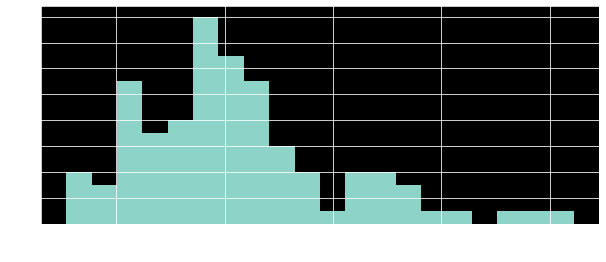

In [25]:
df_max_rul = train['id RUL'.split(' ')].groupby('id').max().reset_index()
df_max_rul['RUL'].hist(bins=20, figsize=(10, 4))
plt.xlabel('RUL')
plt.ylabel('frequency')

With the distribution we can see, that the RUL ofter lies in 200 cycles. The distribution has roughly a normal distribution with some extreme values.  

## Plotting signal values
In order to get an idea, how different sensor values affect the RUL, those sensor signal values are plotted against the RUL values. 
Each plot shows the sensor value plotted against the RUL by using 5 different time series in each id.  

In [26]:
for sensor_value in sensor_names:
    #plot_sensor_signal(train, sensor_value)
    pass

As seen in the plots above, some sensor signals have a slight decrease in sensor value when approaching 0 RUL, while others show an increase. 
There are also signals, which are just straight lines. These can be deemed irrelevant for the model. 
Therefore, we define a list of unwanted sensor signals which will later be dropped from the training set. 

In [27]:
# plot std
# plot_sensor_std(train)

In [28]:
drop_sensors = 's1 s5 s6 s10 s16 s18 s19'.split(' ')
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = 's2 s3 s4 s7 s8 s9 s11 s12 s13 s14 s15 s17 s20 s21'.split(' ')

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
X_test = test.groupby('id').last().reset_index().drop(drop_labels, axis=1)
X_test = X_test.drop('RUL', axis=1)

# Regression models
The first approach is using regression models as means to solve this problem. By using regression, the RUL can be estimated or predicted. 

## Baseline model as reference
In order to be able to assess the improvement or the superiority of a ML model a baseline model with simple linear regression is used. 

In [29]:
# create and fit model
lm = LinearRegression()
start = timer()
lm.fit(X_train, y_train)
end = timer()
time_reg = end - start
print('Time for training of Linear Regression Model: ' + str(round(time_reg, 2)) + 's. ')   
memspace_reg = asizeof.asizeof(lm)
print('Memory allocation of Linear Regression object: ' + str(memspace_reg/1e6) + 'MB')

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')
print('len y_train: ' + str(len(y_train)))
print('len y_test: ' + str(len(y_test)))

y_hat_test = lm.predict(X_test)
rsme_reg = evaluate(y_test, y_hat_test)

# calculate relative error
y_test_array = np.array(y_test['RUL'])
x = y_hat_test - y_test_array
error_re_y_test_reg = abs(100 * (x/y_test_array))

Time for training of Linear Regression Model: 0.02s. 
Memory allocation of Linear Regression object: 0.001384MB
train set RMSE:44.66819159545453, R2:0.5794486527796716
len y_train: 20631
len y_test: 100
test set RMSE:31.952633027737285, R2:0.4087736807659086


## Random Forest model
In order to increase the accuracy of the baseline model the Random Forest model is implemented. 

In [30]:
rf = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=42, max_depth=10, min_samples_leaf=50)  # depth should be less than number of features

# fit model + measure computation time
start = timer()
rf.fit(X_train, y_train)
end = timer()
time_rf = end - start
print('Time for training of Random Forest Model: ' + str(round(time_rf, 2)) + 's. ')   
memspace_rf = asizeof.asizeof(rf)
print('Memory allocation of Random Forest object: ' + str(memspace_rf/1e6) + 'MB')

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
rsme_rf = evaluate(y_test, y_hat_test)        # y_test = ideal solution, while y_hat_test = predicted solution

# calculate relative error 
y_test_array = np.array(y_test['RUL'])
x = y_hat_test - y_test_array
error_re_y_test_rf = abs(100 * (x/y_test_array))
X_test.head()

Time for training of Random Forest Model: 10.64s. 
Memory allocation of Random Forest object: 0.232MB
train set RMSE:39.931480443512434, R2:0.6639119185439148
test set RMSE:30.42435900934061, R2:0.46397711724773816


,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117


## Support Vector Machine
Another ML technique is SVM. This can be used for both classification and regression problems. 

In [31]:
# scale data
sc = MinMaxScaler()
# use transformations: standardisierung
# multiple training runs: with batches (init model with previous)
# use bins for RUL -> could be better, easier for model
# PCA 
# calculate error for each RUL-value: should decrease each cycle

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

# fit
svr = SVR(kernel='rbf', C=0.035, gamma=0.5, degree=3, epsilon=.5, coef0=1)

start = timer()
svr.fit(X_train_sc, y_train)
end = timer()
time_svr = end - start
print('Time for training of SVM Regression Model: ' + str(round(time_svr, 2)) + 's. ')   
memspace_svr = asizeof.asizeof(svr)
print('Memory allocation of SVM Regression object: ' + str(memspace_svr/1e6) + 'MB')


# predict
y_hat_train = svr.predict(X_train_sc)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_sc)
rsme_svr = evaluate(y_test, y_hat_test, 'test')

# calculate relative error 
y_test_array = np.array(y_test['RUL'])
x = y_hat_test - y_test_array
error_re_y_test_svr = abs(100 * (x/y_test_array))

Time for training of SVM Regression Model: 15.56s. 
Memory allocation of SVM Regression object: 2.538872MB
train set RMSE:50.424189026555545, R2:0.46407979325633797
test set RMSE:22.45924205924393, R2:0.7079006116757677


# LSTM regression model

In [32]:
# scaling
remaining_sensors.append('RUL')
train[remaining_sensors]=sc.fit_transform(train[remaining_sensors])
test[remaining_sensors]=sc.transform(test[remaining_sensors])

#to predict with regression
target_col_name_reg = 'RUL'

# generate X_train
X_train = np.array(train[remaining_sensors])

#generate y_train regression
Y_train_reg = train[target_col_name_reg]

# generate X_test
X_test = np.array(test[remaining_sensors])

#generate y_test regression
Y_test_reg = test[target_col_name_reg]


In [33]:
#generate training dataset for LMST
sequence = 50
X_train_LSTM = np.zeros((X_train.shape[0]-sequence,sequence, X_train.shape[1])) #start matrix
id_train = np.reshape(np.array(train['id']),((X_train.shape[0],1)))
X_train_help = np.hstack((id_train, X_train)) #add id in trainings set

for i in range (sequence, X_train.shape[0]-1):          # row (cycle)
    for k in range (0, sequence -1):                    # column (old sensor values)
           for j in range (0, X_train_help.shape[1]-1): # column sekound dimension (sensor values)
                if X_train_help[i-k, 0] - X_train_help[i, 0] >= 0:
                    X_train_LSTM[i-sequence, k, j] = X_train_help[i-k, j+1] #overwrite values

#generate Y train for LMST with same shape
Y_train_LSTM = np.zeros((Y_train_reg.shape[0] - sequence))

for i in range (sequence, Y_train_reg.shape[0]-1): 
    Y_train_LSTM [i-sequence] = Y_train_reg [i]

#generate testing dataset for LMST
X_test_LSTM = np.zeros((X_test.shape[0], sequence, X_test.shape[1]))
id_test = np.reshape(np.array(test['id']),((X_test.shape[0],1)))
X_test_help = np.hstack((id_test, X_test)) #add id in test set

for i in range (0, X_test.shape[0]-1):                 # row (cycle)
    for k in range (0, sequence -1):                   # column (old sensor values)
           for j in range (0, X_test_help.shape[1]-1):        # column sekound dimension (sensor values)
                if i - k >= 0:
                    if X_test_help[i-k, 0] - X_test_help[i, 0] >= 0:
                        X_test_LSTM[i, k, j] = X_test_help[i-k, j+1] #overwrite values
                        
np.shape(X_test_LSTM)

(13096, 50, 15)

In [34]:
nb_features = X_train_LSTM.shape[2]
timestamp=sequence

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           46400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 76,651
Trainable params: 76,651
Non-trainable params: 0
_________________________________________________________________


In [35]:
Y_train_LSTM_reg = np.zeros((Y_train_reg.shape[0] - sequence))

for i in range (sequence, Y_train_reg.shape[0]-1): 
    Y_train_LSTM_reg [i-sequence] = Y_train_reg [i]
    
# fit the network
start = timer()
model.fit(X_train_LSTM, Y_train_LSTM_reg, epochs=20, batch_size=200, validation_split=0.05, verbose=1)
end = timer()
time_lstm = end - start
print('Time for training of LSTM Model: ' + str(round(time_svr, 2)) + 's. ')   
memspace_lstm = asizeof.asizeof(model)
print('Memory allocation of LSTM object: ' + str(memspace_svr/1e6) + 'MB')


Epoch 1/20
98/98 [==============================] - 12s 119ms/step - loss: 0.5379 - accuracy: 0.0049 - val_loss: 0.5189 - val_accuracy: 0.0039
Epoch 2/20
98/98 [==============================] - 11s 114ms/step - loss: 0.5172 - accuracy: 0.0049 - val_loss: 0.5185 - val_accuracy: 0.0039
Epoch 3/20
98/98 [==============================] - 11s 112ms/step - loss: 0.5163 - accuracy: 0.0049 - val_loss: 0.5173 - val_accuracy: 0.0039
Epoch 4/20
98/98 [==============================] - 11s 113ms/step - loss: 0.5160 - accuracy: 0.0049 - val_loss: 0.5177 - val_accuracy: 0.0039
Epoch 5/20
98/98 [==============================] - 11s 117ms/step - loss: 0.5158 - accuracy: 0.0049 - val_loss: 0.5171 - val_accuracy: 0.0039
Epoch 6/20
98/98 [==============================] - 12s 120ms/step - loss: 0.5158 - accuracy: 0.0049 - val_loss: 0.5176 - val_accuracy: 0.0039
Epoch 7/20
98/98 [==============================] - 13s 129ms/step - loss: 0.5160 - accuracy: 0.0049 - val_loss: 0.5173 - val_accuracy: 0.0039

In [36]:
Y_pred_LSTM_reg=model.predict(X_test_LSTM)

scores_reg = model.evaluate(X_train_LSTM, Y_train_LSTM_reg, verbose=1, batch_size=200)

103/103 [==============================] - 5s 45ms/step - loss: 0.5150 - accuracy: 0.0049


In [37]:
# get RUL for each ID
index = 0
list_RUL_lstm = []
list_RUL_lstm = np.array(list_RUL_lstm)
for i in range(0, len(list_periods)):   
    index = index + list_periods[i]
    list_RUL_lstm = np.append(list_RUL_lstm, (340 * Y_pred_LSTM_reg[index - 1]))


In [38]:
df_RUL = pd.DataFrame(list_RUL_lstm, columns=['RUL'])
rsme_lstm = evaluate(y_test, df_RUL, label='lstm')

# calculate relative error 
y_test_array = np.array(y_test['RUL'])
temp = np.array(list_RUL_lstm)
# print(temp)
x = np.array(list_RUL_lstm) - y_test_array
error_re_y_test_lstm = abs(100 * (x/y_test_array))

# error value without last value
x = np.array(list_RUL_lstm[0:99]) - y_test_array[0:99]
y_test_short = y_test_array[0:99]
error_re_y_test_lstm_noend = abs(100 * (x/y_test_short))

lstm set RMSE:18.4513108355227, R2:0.8028508513039563


In [39]:
num_of_values = 99
rsme_lstm_noend = evaluate(y_test['RUL'][0:num_of_values], df_RUL['RUL'][0:num_of_values], label='lstm with last value')

lstm with last value set RMSE:1.9343349604412836, R2:0.9978155558378922


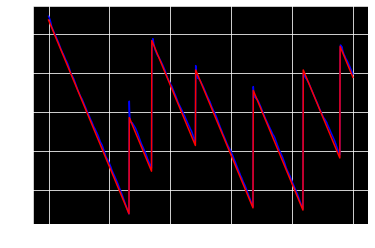

In [40]:
t = np.arange(0, Y_pred_LSTM_reg.shape[0])

#Ausschnitt
a = 6000
e = 7000

plt.plot(t[a:e], Y_pred_LSTM_reg[a:e]*340, 'b')
plt.plot(t[a:e], Y_test_reg[a:e]*340, 'r')
plt.grid(True)

## Comparison of predicted results
Next, we evaluate the predicted results. 

No handles with labels found to put in legend.


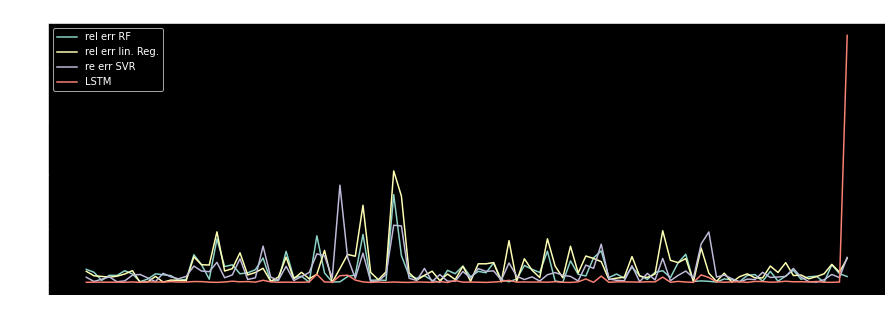

In [41]:
# plotting data

plt.figure(figsize=(15, 5))

plt.title('Error of prediction for each motor id')
plt.legend(loc='upper right')

plt.plot(error_re_y_test_rf)
plt.plot(error_re_y_test_reg)
plt.plot(error_re_y_test_svr)
plt.plot(error_re_y_test_lstm)
plt.xlabel("motor ID")
plt.ylabel('absolute error re y_test in %')
plt.gca().legend(('rel err RF','rel err lin. Reg.', 're err SVR', 'LSTM'))


No handles with labels found to put in legend.


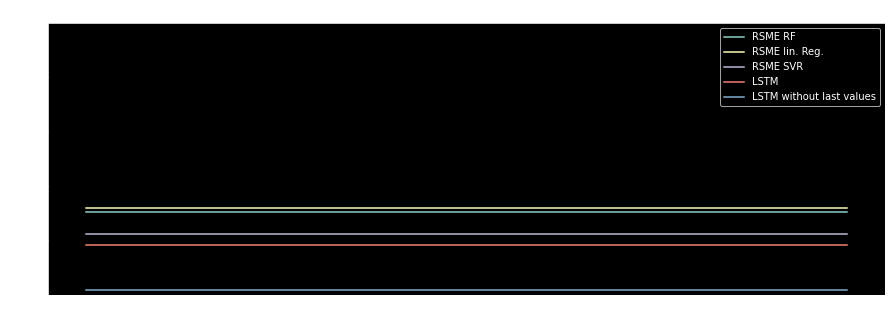

In [42]:
plt.figure(figsize=(15, 5))

plt.title('RSME of prediction for each motor id')
plt.legend(loc='upper right')

plt.ylim(0, 100)
plt.xlabel("value")
plt.ylabel('absolute error re y_test in %')
plt.plot(rsme_rf * np.ones(100))
plt.plot(rsme_reg * np.ones(100))
plt.plot(rsme_svr * np.ones(100))
plt.plot(rsme_lstm * np.ones(100))
plt.plot(rsme_lstm_noend * np.ones(100))
plt.gca().legend(('RSME RF', 'RSME lin. Reg.', 'RSME SVR', 'LSTM', 'LSTM without last values'))

No handles with labels found to put in legend.


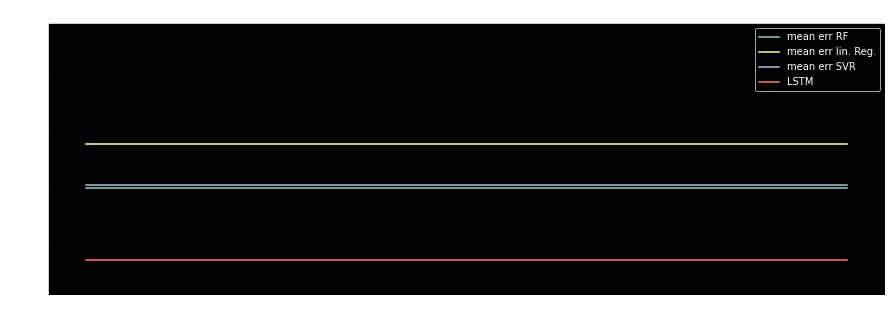

In [43]:
plt.figure(figsize=(15, 5))

plt.title('RMSE of prediction for each motor id')
plt.legend(loc='upper right')

plt.ylim(0, 100)
plt.xlabel("value")
plt.ylabel('absolute error re y_test in %')
plt.plot(np.mean(error_re_y_test_rf) * np.ones(100))
plt.plot(np.mean(error_re_y_test_reg) * np.ones(100))
plt.plot(np.mean(error_re_y_test_svr) * np.ones(100))
plt.plot(np.mean(error_re_y_test_lstm) * np.ones(100))
plt.gca().legend(('mean err RF', 'mean err lin. Reg.', 'mean err SVR', 'LSTM'))

std linear regression: 65.65678240520393


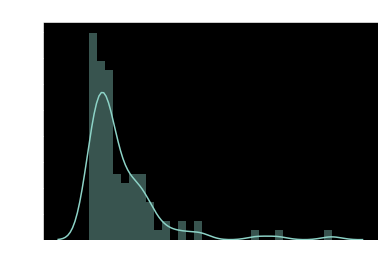

In [44]:
sns.distplot(error_re_y_test_reg, bins=30,axlabel='rel error in %').set_title('linear regression')
print('std linear regression: ' + str(np.std(error_re_y_test_reg)))

std RF: 47.02543389108661


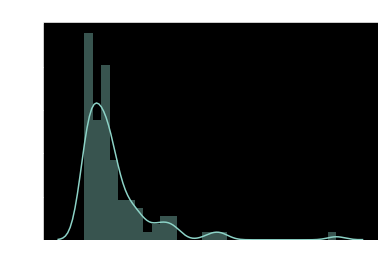

In [45]:
sns.distplot(error_re_y_test_rf, bins=30,axlabel='rel error in %').set_title('Random Forest')
print('std RF: ' + str(np.std(error_re_y_test_rf)))

std SVR: 53.64418347119265


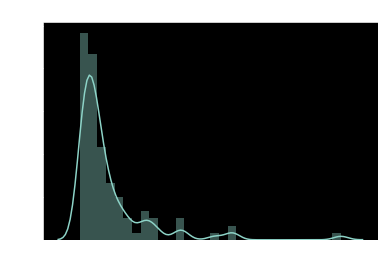

In [46]:
sns.distplot(error_re_y_test_svr, bins=30,axlabel='rel error in %').set_title('SVR')
print('std SVR: ' + str(np.std(error_re_y_test_svr)))

std LSTM: 91.1401620820757


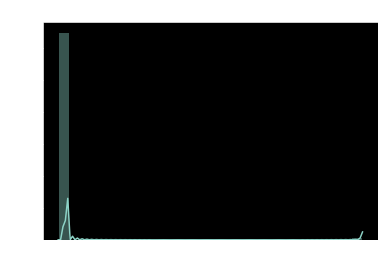

In [47]:
sns.distplot(error_re_y_test_lstm, bins=30,axlabel='rel error in %').set_title('LSTM')
print('std LSTM: ' + str(np.std(error_re_y_test_lstm)))

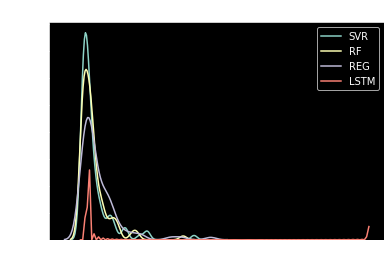

In [48]:
# all distplots in one plot
sns.distplot(error_re_y_test_svr, bins=30,axlabel='rel error in %', hist=False, label='SVR').set_title('Distribution of error')
sns.distplot(error_re_y_test_rf, bins=30,axlabel='rel error in %', hist=False, label='RF')
sns.distplot(error_re_y_test_reg, bins=30,axlabel='rel error in %', hist=False, label='REG')
sns.distplot(error_re_y_test_lstm, bins=30,axlabel='rel error in %', hist=False, label='LSTM')

# Comparison: computation time vs. accuracy/RMSE vs. memory space

In [49]:
comp_times = [time_reg, time_rf, time_svr, time_lstm, time_lstm]                     # in s
accuracies = [rsme_reg, rsme_rf, rsme_svr, rsme_lstm, rsme_lstm_noend]               # in RMSE 
memspaces = [memspace_reg, memspace_rf, memspace_svr, memspace_lstm, memspace_lstm]  # in MB
models = ['REG', 'RF', 'SVR', 'LSTM', 'LSTM no last value']
mem_sizes = np.array(memspaces)
mem_sizes = mem_sizes/1e6

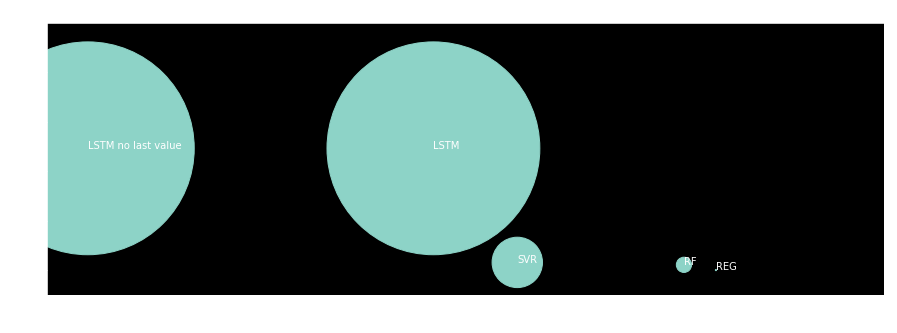

In [50]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x=accuracies, y=comp_times, s=mem_sizes*1000)
plt.xlabel('RSME')
plt.ylabel('computation time in s')
plt.title('Regression models - Computation time vs. RSME vs. memory space')
plt.xlim(0, 40)
plt.ylim(-50, 500)

for i, txt in enumerate(models):
    ax.annotate(txt, (accuracies[i], comp_times[i]))


In [51]:
comp_times = [time_reg, time_rf, time_svr, time_lstm, time_lstm]                  
accuracies = [np.mean(error_re_y_test_reg), np.mean(error_re_y_test_rf), np.mean(error_re_y_test_svr), np.mean(error_re_y_test_lstm), np.mean(error_re_y_test_lstm_noend)]               
memspaces = [memspace_reg, memspace_rf, memspace_svr, memspace_lstm, memspace_lstm]  
models = ['REG', 'RF', 'SVR', 'LSTM', 'LSTM no last value']
mem_sizes = np.array(memspaces)
mem_sizes = mem_sizes/1e6

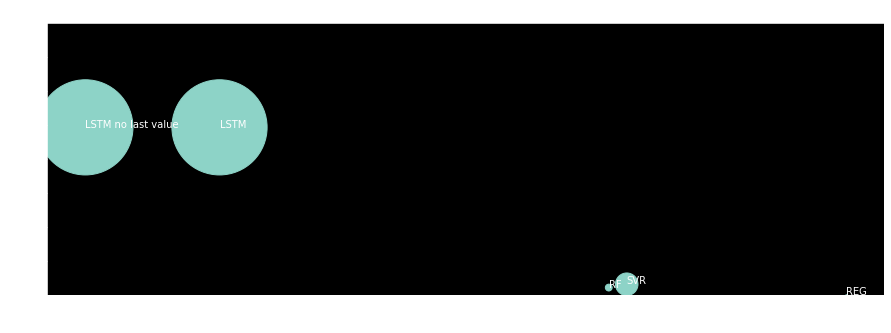

In [52]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x=accuracies, y=comp_times, s=mem_sizes*200)
plt.xlabel('rel error re truth value in %')
plt.ylabel('computation time in s')
plt.title('Regression models - Computation time vs. rel errer re truth value vs. memory space')
# plt.xlim(0, 40)
plt.ylim(0, 400)

for i, txt in enumerate(models):
    ax.annotate(txt, (accuracies[i], comp_times[i]))

## Regression models using SVR
### Approach
For this approach we try to extrapolate the health function for the engines. In order to do so, we first need to classify, which section of the cycles of the engines lifetime is considered healthy. Basically, we first classify the health of the engines in the training set and try to predict that health with regression. 

The health classification goes as followed: 
First 10% of the cycles are considered "healthy", thus are label with a "1". The rest is labeled as unhealthy. 

In [114]:
dir_path = './input/'
train_file = 'PM_train.txt'
train_location = dir_path + train_file
test_file = 'PM_test.txt'
test_location = dir_path + test_file
truth_file = 'PM_truth.txt'
truth_location = dir_path + truth_file

index_names = ['id', 'cycle']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names = ['s{}'.format(i+1) for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv(train_location, sep='\s+', header=None, names=col_names)    # s+ -> regex for spaces/tabs as spaces
test = pd.read_csv(test_location, sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(truth_location, sep='\s+', header=None, names=['RUL'])

In [115]:
# Computation of RUL
train = add_remaining_useful_life(train)
test = add_remaining_useful_life(test)
train[index_names+['RUL']].head()


,id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [116]:
# adjust RUL value by truth values
for i in range(len(test)):
    currentID = test['id'][i]
    current_truth_value = y_test['RUL'][currentID - 1]
    test['RUL'][i] = test['RUL'][i] + current_truth_value


In [146]:
# add health feature for train set
train['health'] = train['health'] = np.zeros(len(train))

index = 0
for i in range(max(train['id'])):
    print('index: ' + str(index))
    max_health = train['RUL'][index] + 1
    healthy_cycles = math.ceil(max_health*0.3)
    for j in range(index, index +healthy_cycles, 1):
        train['health'][j] = 1
    index = index + max_health

# add health feature for train set
test['health'] = test['health'] = np.zeros(len(test))


index: 0
index: 192
index: 479
index: 658
index: 847
index: 1116
index: 1304
index: 1563
index: 1713
index: 1914
index: 2136
index: 2376
index: 2546
index: 2709
index: 2889
index: 3096
index: 3305
index: 3581
index: 3776
index: 3934
index: 4168
index: 4363
index: 4565
index: 4733
index: 4880
index: 5110
index: 5309
index: 5465
index: 5630
index: 5793
index: 5987
index: 6221
index: 6412
index: 6612
index: 6807
index: 6988
index: 7146
index: 7316
index: 7510
index: 7638
index: 7826
index: 8042
index: 8238
index: 8445
index: 8637
index: 8795
index: 9051
index: 9265
index: 9496
index: 9711
index: 9909
index: 10122
index: 10335
index: 10530
index: 10787
index: 10980
index: 11255
index: 11392
index: 11539
index: 11770
index: 11942
index: 12127
index: 12307
index: 12481
index: 12764
index: 12917
index: 13119
index: 13432
index: 13631
index: 13993
index: 14130
index: 14338
index: 14551
index: 14764
index: 14930
index: 15159
index: 15369
index: 15523
index: 15754
index: 15953
index: 16138
index

In [118]:
drop_sensors = 's1 s5 s6 s10 s16 s18 s19'.split(' ')
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = 's2 s3 s4 s7 s8 s9 s11 s12 s13 s14 s15 s17 s20 s21'.split(' ')

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('health')
X_test = test.groupby('id').last().reset_index().drop(drop_labels, axis=1)
X_test = X_test.drop('RUL', axis=1)

In [119]:
test.head(30)
len(test)
y_train.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: health, dtype: float64

In [150]:
# scale data
sc = MinMaxScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

# fit
svr = SVR(kernel='sigmoid')

svr.fit(X_train_sc, y_train)

# predict
y_hat_train = svr.predict(X_train_sc)

y_hat_test = svr.predict(X_test_sc)

In [169]:
max(train['cycle'])
current_data = y_hat_train[0:192]
padded = np.pad(current_data, (0, 300-len(current_data)), 'constant', constant_values=(None, None))
len(list_periods_train)

100

max cycles: 362
index: 0
end: 192
datalen: 192
index: 192
end: 479
datalen: 287
index: 671
end: 850
datalen: 179
index: 1521
end: 1710
datalen: 189
index: 3231
end: 3500
datalen: 269
index: 6731
end: 6919
datalen: 188
index: 13650
end: 13909
datalen: 259
index: 27559
end: 27709
datalen: 0
index: 55268
end: 55469
datalen: 0
index: 110737
end: 110959
datalen: 0
index: 221696
end: 221936
datalen: 0
index: 443632
end: 443802
datalen: 0
index: 887434
end: 887597
datalen: 0
index: 1775031
end: 1775211
datalen: 0
index: 3550242
end: 3550449
datalen: 0
index: 7100691
end: 7100900
datalen: 0
index: 14201591
end: 14201867
datalen: 0
index: 28403458
end: 28403653
datalen: 0
index: 56807111
end: 56807269
datalen: 0
index: 113614380
end: 113614614
datalen: 0
index: 227228994
end: 227229189
datalen: 0
index: 454458183
end: 454458385
datalen: 0
index: 908916568
end: 908916736
datalen: 0
index: 1817833304
end: 1817833451
datalen: 0
index: 3635666755
end: 3635666985
datalen: 0
index: 7271333740
end: 72

Text(0, 0.5, 'health indicator')

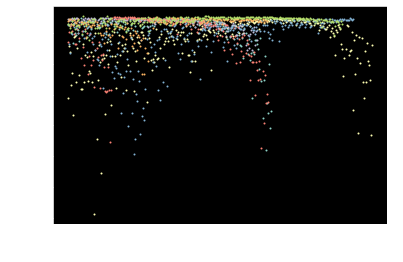

In [174]:
# plot data with padding
max_cycle = max(train['cycle'])
print('max cycles: ' + str(max_cycle))
index = 0
for i in range(len(list_periods_train)):
    end = index + list_periods_train[i]
    # print('index: ' + str(index))
    # print('end: ' + str(end))
    current_data = y_hat_train[index:end]
    # print('datalen: ' + str(len(current_data)))
    current_data = np.pad(current_data, (0, max_cycle-len(current_data)), 'constant', constant_values=(None, None))
    plt.scatter(x=range(0, max_cycle), y=current_data[0:max_cycle], s=1)
    # plt.plot(current_data[0:max_cycle])
    index = index + end

# plt.scatter(y=y_hat_train[:192], x=range(0, 192), s=2)
plt.xlabel('times in cycles')
plt.ylabel('health indicator')